<a href="https://colab.research.google.com/github/cteliStolenFocus/aai-511-team-8/blob/main/AAI511_Final_Project_Team_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###########################################################################
# AAI 511 - Final Project - Team 8
## Predict a Composer with a MIDI Dataset
Christopher Teli, Ikenna Opurum, Adam Graves
###########################################################################

###Tasks Breakdown
* Data Collection: Data is collected and provided to you.
* Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
* Feature Extraction: Extractfeatures from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
* Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
* Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
* Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
* Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.





In [ ]:
#Install library for loading a MIDI file
!pip install pretty_midi
!pip install librosa
!pip install pydot graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 6.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592285 sha256=2b4eb58bcce87d980975b116b56ac1a17aa8dc41a36f35750b4b4f8a64af3158
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.3.2 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


In [ ]:
#if needed to mount a google drive for the data (our testing does)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading data from github for the project
!git clone https://github.com/cteliStolenFocus/aai-511-team-8

Cloning into 'aai-511-team-8'...
Updating files:  61% (468/758)
Updating files:  62% (470/758)
Updating files:  63% (478/758)
Updating files:  64% (486/758)
Updating files:  65% (493/758)
Updating files:  66% (501/758)
Updating files:  67% (508/758)
Updating files:  68% (516/758)
Updating files:  69% (524/758)
Updating files:  70% (531/758)
Updating files:  71% (539/758)
Updating files:  72% (546/758)
Updating files:  73% (554/758)
Updating files:  74% (561/758)
Updating files:  75% (569/758)
Updating files:  76% (577/758)
Updating files:  77% (584/758)
Updating files:  78% (592/758)
Updating files:  79% (599/758)
Updating files:  80% (607/758)
Updating files:  81% (614/758)
Updating files:  82% (622/758)
Updating files:  83% (630/758)
Updating files:  84% (637/758)
Updating files:  85% (645/758)
Updating files:  86% (652/758)
Updating files:  87% (660/758)
Updating files:  88% (668/758)
Updating files:  89% (675/758)
Updating files:  90% (683/758)
Updating files:  91% (690/758)
Updati

In [ ]:
#@title 1: Functions for Data Collection
# Function for Feature extractions
import os
import glob
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from keras import models, layers

# Check if pickle file exists and use the file for dataset
import pickle

In [ ]:
#@title 2: Directory of MIDI files for Google Drive
base_dir = '/content/drive/MyDrive/AAI-511/Load Data/Final' # Google Drive
# base_dir in local machine
#base_dir = 'train'

# # Directory of MIDI files
# base_dir = 'train'

# Specify the path and filename of the pickle file
# Since the pkl file exists, that means the data was processed and features extracted
pickle_file_name = 'team8_composer_dataset.pkl'


# #@title 2: Do Data Extraction (ETL) process
# # Directory of MIDI files
# # To support multiple developer environments we will set the base_dir accordingly
# def environment_base_dir():
#     try:
#         # Check for Google Colab
#         from google.colab import drive
#         return "/content/aai-511-team-8/train"
#     except ImportError:
#         # Check for Jupyter Notebook
#         print('Checking Jupyter notebook')
#         try:
#             cfg = get_ipython().config
#             if cfg is not None:
#                 return "aai-511-team-8/train"
#         except:
#             return None

# base_dir = environment_base_dir()
# print(f"Using base_dir {base_dir}")

# # Specify the path and filename of the pickle file
# # Since the pkl file exists, that means the data was processed and features extracted
# pickle_file_name = 'team8_composer_dataset.pkl'

In [ ]:
#@title 2.1: Extract features using librosa for further feature extraction (ETL)
#newer version of code
def calculate_features(midi_file):
    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    # Time interval for calculating features
    interval = 1.0  # 1 second
    times = np.arange(0, midi_data.get_end_time(), interval)

    # Create arrays for storing time series data
    pitch = np.zeros(len(times))
    volume = np.zeros(len(times))
    note_density = np.zeros(len(times))
    tempo = np.zeros(len(times))

    # Calculate time series data for each feature
    for i, t in enumerate(times):
        # Get notes that are playing at this time
        notes = [note for note in midi_data.instruments[0].notes if note.start <= t < note.end]

        # Calculate average pitch
        if notes:
            pitch[i] = np.mean([note.pitch for note in notes])

        # Calculate note density (notes per second)
        note_density[i] = len(notes) / interval

        # Calculate average volume
        if notes:
            volume[i] = np.mean([note.velocity for note in notes])

    # Calculate rhythmic complexity (variance in inter-onset intervals)
    inter_onset_intervals = np.diff([note.start for note in midi_data.instruments[0].notes])
    rhythmic_complexity = np.var(inter_onset_intervals)

    # Calculate tempo for each moment in time
    tempo_changes = midi_data.get_tempo_changes()
    tempo = np.interp(times, tempo_changes[0], tempo_changes[1])

    return times, pitch, note_density, volume, rhythmic_complexity, tempo

In [ ]:
#@title 2.2: Process composer data to df
def process_composer_data():
    # Initialize DataFrame
    df = pd.DataFrame(columns=["Composer","Times", "Pitch", "Note_Density", "Volume",
                               "Rhythmic_Complexity", "Tempo"])

    # Iterate over all composer directories
    for composer_dir in glob.glob(os.path.join(base_dir, '*')):
        # Get the composer's name
        composer_name = os.path.basename(composer_dir)
        print(f"Processing {composer_name} MIDI files...")

        # Iterate over all MIDI files in composer's directory
        for midi_file in glob.glob(os.path.join(composer_dir, '*.mid')):
            print(f"Processing {midi_file}...")
            try:
                times, pitch, note_density, volume, rhythmic_complexity, tempo = calculate_features(midi_file)
                # Append to DataFrame
                df = df.append({"Composer": composer_name, "Times": times, "Pitch": pitch,
                                "Note_Density": note_density, "Volume": volume,
                                "Rhythmic_Complexity": rhythmic_complexity,
                                "Tempo": tempo},
                               ignore_index=True)
            except Exception as e:
                print(f"Error processing {midi_file}: {str(e)}")

    # Write the DataFrame to a pickle file
    df.to_pickle(base_dir + "/" + pickle_file_name)

    return df

In [ ]:
#@title 2.3: Data Processing - Feature extraction

pickle_file = base_dir + "/" + pickle_file_name
# Check if the pickle file exists
if not os.path.exists(pickle_file):
    print("Music Data not Pickled, creating dataset using feature extract.")
    df = process_composer_data()
else:
    # Open the pickle file in binary mode and load the data
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)

    # Create a DataFrame from the loaded data
    df = pd.DataFrame(data)

    # Now you have your DataFrame ready for use
    print(df.head())

  Composer                                              Times  \
0     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
2     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
3     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   

                                               Pitch  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0,...   
1  [0.0, 78.0, 78.0, 0.0, 66.0, 66.0, 0.0, 0.0, 6...   
2  [0.0, 67.0, 43.0, 0.0, 67.0, 0.0, 43.0, 55.0, ...   
3  [0.0, 0.0, 50.0, 74.0, 0.0, 74.0, 0.0, 74.0, 0...   
4  [0.0, 63.0, 69.0, 0.0, 0.0, 69.0, 0.0, 45.0, 0...   

                                        Note_Density  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1  [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...   
2  [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...   
3  [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0,

In [ ]:
#@title 2.4: Data Pre-processing - verifications
print(df.head())
print(df.info())

  Composer                                              Times  \
0     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
2     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
3     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   

                                               Pitch  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0,...   
1  [0.0, 78.0, 78.0, 0.0, 66.0, 66.0, 0.0, 0.0, 6...   
2  [0.0, 67.0, 43.0, 0.0, 67.0, 0.0, 43.0, 55.0, ...   
3  [0.0, 0.0, 50.0, 74.0, 0.0, 74.0, 0.0, 74.0, 0...   
4  [0.0, 63.0, 69.0, 0.0, 0.0, 69.0, 0.0, 45.0, 0...   

                                        Note_Density  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1  [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...   
2  [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...   
3  [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0,

In [ ]:
#@title 2.5: Check df
df.head()

,Composer,Times,Pitch,Note_Density,Volume,Rhythmic_Complexity,Tempo
0,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 127.0...",4.609656,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
1,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 78.0, 78.0, 0.0, 66.0, 66.0, 0.0, 0.0, 6...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0, 127.0, 127.0, 0.0, 127.0, 127.0, 0.0, 0....",1.625026,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
2,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 67.0, 43.0, 0.0, 67.0, 0.0, 43.0, 55.0, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...","[0.0, 127.0, 127.0, 0.0, 127.0, 0.0, 127.0, 12...",2.137464,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
3,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 50.0, 74.0, 0.0, 74.0, 0.0, 74.0, 0...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 127.0, 127.0, 0.0, 127.0, 0.0, 127....",1.291966,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
4,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 63.0, 69.0, 0.0, 0.0, 69.0, 0.0, 45.0, 0...","[0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[0.0, 127.0, 127.0, 0.0, 0.0, 127.0, 0.0, 127....",0.866606,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."


In [ ]:
#@title 2.6: Check composer names and Count the occurrences of each 'quality' value
composer_counts = df['Composer'].value_counts()

# Sort the count by 'quality' values
sorted_composer_counts = composer_counts.sort_index()

# Print the count for each 'quality' value
print(sorted_composer_counts)

bach           42
bartok         41
byrd           42
chopin         41
handel         41
hummel         42
mendelssohn    41
mozart         41
schumann       38
Name: Composer, dtype: int64


In [ ]:
#@title 2.7: Check on df shape and info
print(df.shape)
print(df.describe())

(369, 7)
       Rhythmic_Complexity
count           369.000000
mean              4.887834
std              27.596210
min               0.000153
25%               0.111875
50%               0.529536
75%               1.486953
max             356.946073


In [ ]:
#@title 3: Preparing the data for LSTM
#Load related libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# Convert all other features to have an extra dimension for LSTM
def transform_series(series, num_steps):
    # Reshape series to (samples, time_steps, features)
    X = np.zeros((len(series), num_steps, 1))
    for i in range(len(series)):
        X[i,:,0] = series.iloc[i][:num_steps]
    return X

In [ ]:
#@title 3.1: Split train and test data sets (80-20)
# Using stratify to ensure the datasets have same prorportions of each composer as original dataset
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Composer'])

# Second, we separate the remaining data into the train and validation sets (75-25)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=42, stratify=df_train_val['Composer'])

# The train/val/test split is now 60%/20%/20%

# Encode the labels
encoder = LabelEncoder()
encoder.fit(df['Composer'])  # Fit on the whole dataset

# Transform the labels to one-hot encoded form for each subset
y_train = np_utils.to_categorical(encoder.transform(df_train['Composer']))
y_val = np_utils.to_categorical(encoder.transform(df_val['Composer']))
y_test = np_utils.to_categorical(encoder.transform(df_test['Composer']))

In [ ]:
#@title 3.2: Apply transform_series on each feature for each subset
def prepare_data(df, num_steps):
    pitch = transform_series(df['Pitch'], num_steps)
    note_density = transform_series(df['Note_Density'], num_steps)
    volume = transform_series(df['Volume'], num_steps)
    rhythmic_complexity = np.array([df['Rhythmic_Complexity'].values]*num_steps).T[:,:,np.newaxis]
    tempo = transform_series(df['Tempo'], num_steps)

    X = np.concatenate([pitch, note_density, volume, rhythmic_complexity, tempo], axis=-1)
    return X

num_steps = 27
X_train = prepare_data(df_train, num_steps)
X_val = prepare_data(df_val, num_steps)
X_test = prepare_data(df_test, num_steps)

In [ ]:
#@title 3.3: Validate shapes
print(y_train.shape[1])
print(X_val.shape)
print(y_train)

9
(74, 27, 5)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#@title 3.4: X_Train shape validation
X_train.shape

(221, 27, 5)

Notes: X_train contains 221 samples, 27 time_steps and 5 features

In [ ]:
#@title 3.5v: Reshape the input data to make it 2D
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [ ]:
#@title 3.6v: Scale the data using StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

#Build an LSTM Model (Ver.1)

In [ ]:
#@title 4v: LSTM Model Building V1 (One Layer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

num_classes = y_train.shape[1]
num_features = 5
model = Sequential([
    LSTM(50, activation='relu', input_shape=(num_steps, num_features)),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 50)                11200     
                                                                 
 dense_21 (Dense)            (None, 9)                 459       
                                                                 
Total params: 11,659
Trainable params: 11,659
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title 4.1: LSTM V1 Model Training

# LSTM Model Training
history1 = model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], num_steps, num_features),
                    y_train, epochs=50, validation_data=(X_val_scaled.reshape(X_val_scaled.shape[0], num_steps, num_features), y_val))

Epoch 1/50
7/7 [==============================] - 2s 64ms/step - loss: 2.2547 - accuracy: 0.1312 - val_loss: 2.3025 - val_accuracy: 0.1081
Epoch 2/50
7/7 [==============================] - 0s 19ms/step - loss: 2.1417 - accuracy: 0.1584 - val_loss: 2.3461 - val_accuracy: 0.1216
Epoch 3/50
7/7 [==============================] - 0s 19ms/step - loss: 2.0926 - accuracy: 0.1991 - val_loss: 2.7428 - val_accuracy: 0.1351
Epoch 4/50
7/7 [==============================] - 0s 19ms/step - loss: 2.0270 - accuracy: 0.2353 - val_loss: 4.0159 - val_accuracy: 0.1757
Epoch 5/50
7/7 [==============================] - 0s 19ms/step - loss: 1.9513 - accuracy: 0.2805 - val_loss: 3.9532 - val_accuracy: 0.1757
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 1.9368 - accuracy: 0.3032 - val_loss: 4.1216 - val_accuracy: 0.2027
Epoch 7/50
7/7 [==============================] - 0s 18ms/step - loss: 2.0618 - accuracy: 0.3303 - val_loss: 4.2791 - val_accuracy: 0.2162
Epoch 8/50
7/7 [===========

In [ ]:
#@title 4.1v: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features), y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

3/3 [==============================] - 0s 5ms/step - loss: 1.7956 - accuracy: 0.4459
Test Loss: 1.7955890893936157
Test Accuracy: 0.44594594836235046


In [ ]:
#@title 5: Plot the training and validation loss V1
def plot_learning_curves(history):
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()
    return plot_learning_curves


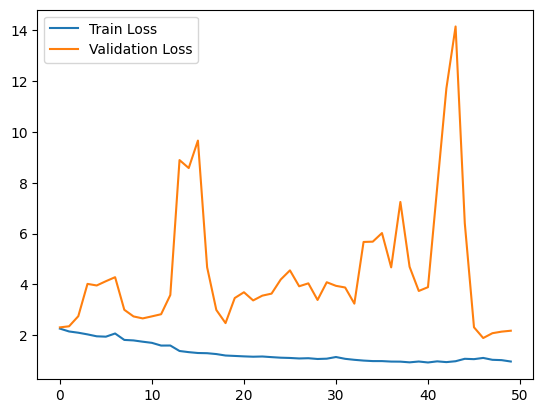

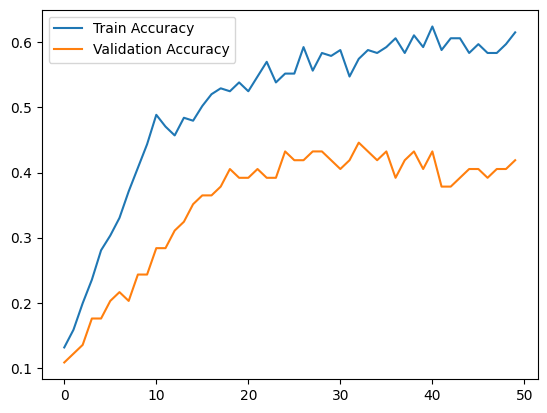

<function __main__.plot_learning_curves(history)>

In [ ]:
#@title 5.1: Show plot
plot_learning_curves(history1)

Notes: The LSTM Ver. 1 model needs improvement in its architecture or training process, as it is underperforming. Next step is to improve the model's performance by adding more layers and increasing the number of epochs.

In [ ]:
#@title 6: Make predictions on the scaled and reshaped test set V1
y_test_pred = model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features))

# Convert predicted probabilities to class labels
y_test_pred_class = np.argmax(y_test_pred, axis=1)

3/3 [==============================] - 0s 5ms/step


In [ ]:
#@title 6.1: Print the true class labels and predicted class labels
for true_label, pred_label in zip(y_test, y_test_pred_class):
    true_class = encoder.inverse_transform([np.argmax(true_label)])[0]
    pred_class = encoder.inverse_transform([pred_label])[0]
    print(f"True Class: {true_class}, Predicted Class: {pred_class}")

True Class: bach, Predicted Class: bach
True Class: mozart, Predicted Class: schumann
True Class: chopin, Predicted Class: chopin
True Class: hummel, Predicted Class: mendelssohn
True Class: hummel, Predicted Class: mendelssohn
True Class: handel, Predicted Class: mozart
True Class: handel, Predicted Class: handel
True Class: mendelssohn, Predicted Class: hummel
True Class: bach, Predicted Class: bach
True Class: schumann, Predicted Class: chopin
True Class: hummel, Predicted Class: hummel
True Class: chopin, Predicted Class: schumann
True Class: hummel, Predicted Class: mendelssohn
True Class: hummel, Predicted Class: schumann
True Class: bach, Predicted Class: bach
True Class: chopin, Predicted Class: chopin
True Class: mozart, Predicted Class: mozart
True Class: bach, Predicted Class: bach
True Class: mozart, Predicted Class: bartok
True Class: bach, Predicted Class: bach
True Class: mendelssohn, Predicted Class: mendelssohn
True Class: mozart, Predicted Class: mendelssohn
True Clas

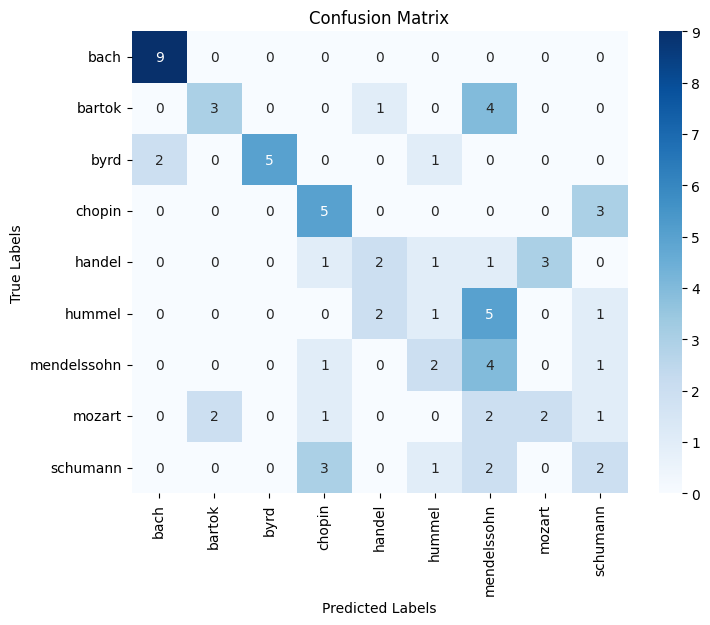

In [ ]:
#@title 6.2: Print a confusion matrix V1
from sklearn.metrics import confusion_matrix
import seaborn as sns
#mport matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_class)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#@title 6.3: Report the confusion matrix V1
# Reshape the input data for prediction
X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features)

# Make predictions on the reshaped test set
y_test_pred = model.predict(X_test_scaled_reshaped)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Convert predicted class labels back to original composer labels using the encoder
lstm_pred_labels = encoder.inverse_transform(y_test_pred_class)
lstm_true_labels = encoder.inverse_transform(np.argmax(y_test, axis=1))  # Convert true class labels back

# Print the classification report
lstm_classification_report_v1 = classification_report(lstm_true_labels, lstm_pred_labels, target_names=encoder.classes_)
print("Classification Report - LSTM Model ver 1:\n", lstm_classification_report_v1)

3/3 [==============================] - 0s 5ms/step
Classification Report - LSTM Model ver 1:
               precision    recall  f1-score   support

        bach       0.82      1.00      0.90         9
      bartok       0.60      0.38      0.46         8
        byrd       1.00      0.62      0.77         8
      chopin       0.45      0.62      0.53         8
      handel       0.40      0.25      0.31         8
      hummel       0.17      0.11      0.13         9
 mendelssohn       0.22      0.50      0.31         8
      mozart       0.40      0.25      0.31         8
    schumann       0.25      0.25      0.25         8

    accuracy                           0.45        74
   macro avg       0.48      0.44      0.44        74
weighted avg       0.48      0.45      0.44        74



Notes: The prediction from the LSTM model version 1 didn't yield good scores. Also, we see from the Classification Report that some composer predictions do better than others. Therefore, these scores need further analysis and experimentation to identify and implement the necessary adjustments.

#Version 2: LSTM with 3 Hidden Layers

In [ ]:
#@title 7: LSTM Model Building V2
#from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(patience=15)

num_classes = y_train.shape[1]
num_features = 5
model = Sequential([
    LSTM(128, activation='relu', input_shape=(num_steps, num_features), return_sequences=True),  # Note the return_sequences=True
    LSTM(64, activation='relu',return_sequences=True),  # Adding another LSTM layer
    LSTM(32, activation='relu'),  # Adding another LSTM layer
    Dense(num_classes, activation='softmax')
]) # 3 Hidden Layers

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 27, 128)           68608     
                                                                 
 lstm_49 (LSTM)              (None, 27, 64)            49408     
                                                                 
 lstm_50 (LSTM)              (None, 32)                12416     
                                                                 
 dense_22 (Dense)            (None, 9)                 297       
                                                                 
Total params: 130,729
Trainable params: 130,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title 7.1: LSTM Model Training V2
history2 = model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], num_steps, num_features),
                    y_train, epochs=100,
                    validation_data=(X_val_scaled.reshape(X_val_scaled.shape[0], num_steps, num_features), y_val)
)

Epoch 1/100
7/7 [==============================] - 6s 137ms/step - loss: 2.1916 - accuracy: 0.1765 - val_loss: 2.5540 - val_accuracy: 0.2162
Epoch 2/100
7/7 [==============================] - 0s 53ms/step - loss: 2.1359 - accuracy: 0.2805 - val_loss: 2.0991 - val_accuracy: 0.2297
Epoch 3/100
7/7 [==============================] - 0s 51ms/step - loss: 2.1983 - accuracy: 0.3032 - val_loss: 2.9446 - val_accuracy: 0.2027
Epoch 4/100
7/7 [==============================] - 0s 51ms/step - loss: 2.1657 - accuracy: 0.3620 - val_loss: 2.3599 - val_accuracy: 0.3243
Epoch 5/100
7/7 [==============================] - 0s 51ms/step - loss: 1.8420 - accuracy: 0.4480 - val_loss: 3.2774 - val_accuracy: 0.3649
Epoch 6/100
7/7 [==============================] - 0s 51ms/step - loss: 1.8205 - accuracy: 0.4389 - val_loss: 4.0641 - val_accuracy: 0.3243
Epoch 7/100
7/7 [==============================] - 0s 52ms/step - loss: 1.7229 - accuracy: 0.3937 - val_loss: 2.8402 - val_accuracy: 0.3784
Epoch 8/100
7/7 [==

In [ ]:
#@title 7.2: Evaluate the model V2
test_loss, test_accuracy = model.evaluate(X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features), y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

3/3 [==============================] - 0s 13ms/step - loss: 8.9251 - accuracy: 0.5270
Test Loss: 8.925073623657227
Test Accuracy: 0.5270270109176636


Notes: This model shows signs of possible overfitting. At fifty percent training accuracy, the model needs to be further evaluated and adjusted to improve its generalization ability.

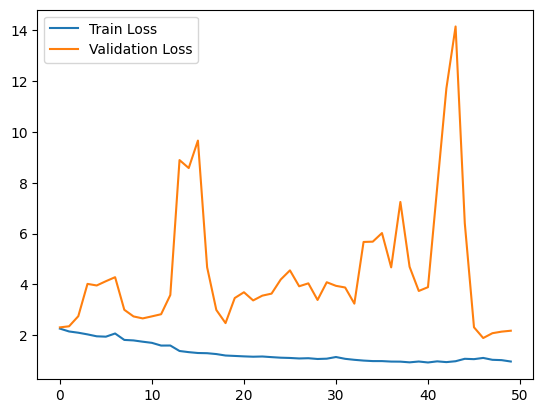

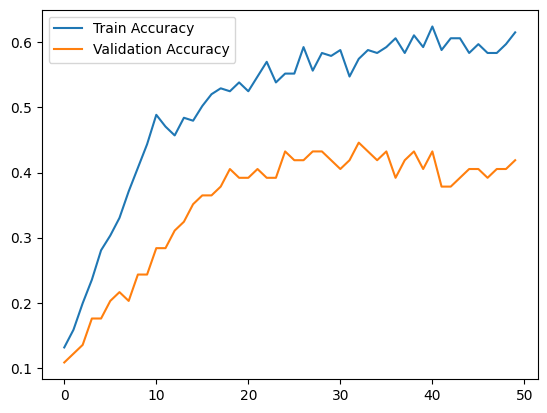

<function __main__.plot_learning_curves(history)>

In [ ]:
#@title 8: Plot v2
plot_learning_curves(history2)

In [ ]:
#@title 9: Save the model - And run predictions V2
model.save('team8_composer_model.h5') #file name

# Load the model
from tensorflow.keras.models import load_model
model = load_model('team8_composer_model.h5')

#6v2: Make predictions on the scaled and reshaped test set
y_test_pred = model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features))

# Convert predicted probabilities to class labels
y_test_pred_class = np.argmax(y_test_pred, axis=1)

3/3 [==============================] - 0s 13ms/step


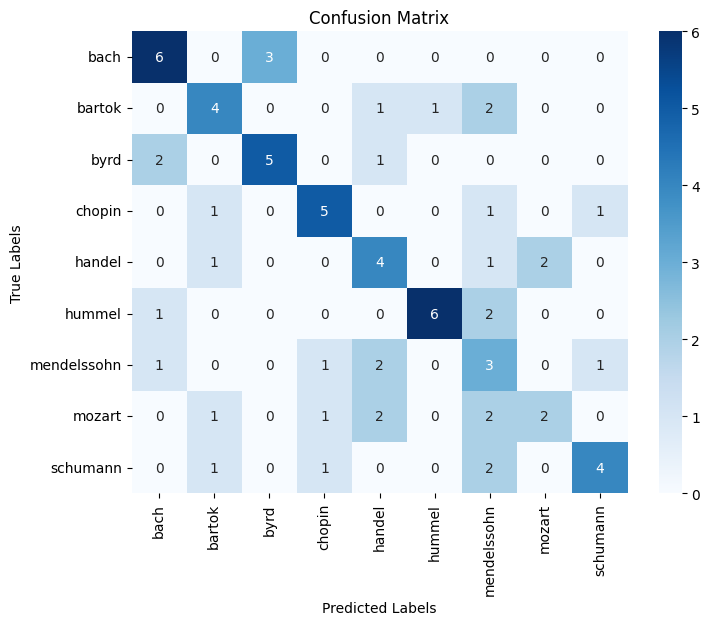

In [ ]:
#@title 10.1: Plot the confusion matrix V2
# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_class)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#@title 10.2: Report the confusion matrix V2
# Reshape the input data for prediction
X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features)

# Make predictions on the reshaped test set
y_test_pred = model.predict(X_test_scaled_reshaped)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Convert predicted class labels back to original composer labels using the encoder
lstm_pred_labels = encoder.inverse_transform(y_test_pred_class)
lstm_true_labels = encoder.inverse_transform(np.argmax(y_test, axis=1))  # Convert true class labels back

# Print the classification report
lstm_classification_report_v2 = classification_report(lstm_true_labels, lstm_pred_labels, target_names=encoder.classes_)
print("Classification Report - LSTM Model Version 2:\n", lstm_classification_report_v2)

3/3 [==============================] - 0s 12ms/step
Classification Report - LSTM Model Version 2:
               precision    recall  f1-score   support

        bach       0.60      0.67      0.63         9
      bartok       0.50      0.50      0.50         8
        byrd       0.62      0.62      0.62         8
      chopin       0.62      0.62      0.62         8
      handel       0.40      0.50      0.44         8
      hummel       0.86      0.67      0.75         9
 mendelssohn       0.23      0.38      0.29         8
      mozart       0.50      0.25      0.33         8
    schumann       0.67      0.50      0.57         8

    accuracy                           0.53        74
   macro avg       0.56      0.52      0.53        74
weighted avg       0.56      0.53      0.53        74



Notes: The scores didn't improve much from those of the first LSTM model. Techniques such as regularization or increasing the size of the training dataset could be considered to mitigate the overfitting issue.

#Version 3 of LSTM, changing the Optimizer and doing an Earlystop

In [ ]:
#@title 11: Updating more variables in the LSTM model and optimizer V3
from tensorflow.keras.optimizers import Adamax

#@title 7: LSTM Model Building
from tensorflow.keras.callbacks import EarlyStopping

# Adding an early stop to prevent overfitting
early_stopping = EarlyStopping(patience=15)

#define the optimizer
learning_rate = 0.01
optimizer = Adamax(learning_rate=learning_rate)

#Build the model
num_classes = y_train.shape[1]
num_features = 5
model = Sequential([
    LSTM(128, activation='relu', input_shape=(num_steps, num_features), return_sequences=True),  # Note the return_sequences=True
    LSTM(64, activation='relu',return_sequences=True),  # Adding another LSTM layer
    LSTM(32, activation='relu'),  # Adding another LSTM layer
    Dense(num_classes, activation='softmax')
]) # 3 Hidden Layers

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 27, 128)           68608     
                                                                 
 lstm_52 (LSTM)              (None, 27, 64)            49408     
                                                                 
 lstm_53 (LSTM)              (None, 32)                12416     
                                                                 
 dense_23 (Dense)            (None, 9)                 297       
                                                                 
Total params: 130,729
Trainable params: 130,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title 11.1: LSTM Model Training V3
history3 = model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], num_steps, num_features),
                    y_train, epochs=100,
                    validation_data=(X_val_scaled.reshape(X_val_scaled.shape[0], num_steps, num_features), y_val),
                    callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 4s 133ms/step - loss: 2.7614 - accuracy: 0.1403 - val_loss: 2.1992 - val_accuracy: 0.2027
Epoch 2/100
7/7 [==============================] - 0s 52ms/step - loss: 2.0892 - accuracy: 0.2308 - val_loss: 2.1986 - val_accuracy: 0.1622
Epoch 3/100
7/7 [==============================] - 0s 53ms/step - loss: 2.0244 - accuracy: 0.2262 - val_loss: 4.3276 - val_accuracy: 0.1757
Epoch 4/100
7/7 [==============================] - 0s 52ms/step - loss: 1.9312 - accuracy: 0.2534 - val_loss: 3.9682 - val_accuracy: 0.2432
Epoch 5/100
7/7 [==============================] - 0s 51ms/step - loss: 1.8659 - accuracy: 0.2715 - val_loss: 2.1988 - val_accuracy: 0.2432
Epoch 6/100
7/7 [==============================] - 0s 52ms/step - loss: 1.8963 - accuracy: 0.2715 - val_loss: 2.8588 - val_accuracy: 0.2297
Epoch 7/100
7/7 [==============================] - 0s 54ms/step - loss: 1.8876 - accuracy: 0.2805 - val_loss: 3.8029 - val_accuracy: 0.2162
Epoch 8/100
7/7 [==

In [ ]:
#@title 11.2: Report the confusion matrix V3
# Reshape the input data for prediction
X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features)

# Make predictions on the reshaped test set
y_test_pred = model.predict(X_test_scaled_reshaped)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Convert predicted class labels back to original composer labels using the encoder
lstm_pred_labels = encoder.inverse_transform(y_test_pred_class)
lstm_true_labels = encoder.inverse_transform(np.argmax(y_test, axis=1))  # Convert true class labels back

# Print the classification report
lstm_classification_report_v3 = classification_report(lstm_true_labels, lstm_pred_labels, target_names=encoder.classes_)
print("Classification Report - LSTM Model Version 3:\n", lstm_classification_report_v3)

3/3 [==============================] - 0s 14ms/step
Classification Report - LSTM Model Version 3:
               precision    recall  f1-score   support

        bach       0.71      0.56      0.63         9
      bartok       0.36      0.50      0.42         8
        byrd       0.55      0.75      0.63         8
      chopin       0.44      1.00      0.62         8
      handel       0.22      0.25      0.24         8
      hummel       0.00      0.00      0.00         9
 mendelssohn       0.14      0.12      0.13         8
      mozart       0.20      0.12      0.15         8
    schumann       0.83      0.62      0.71         8

    accuracy                           0.43        74
   macro avg       0.39      0.44      0.39        74
weighted avg       0.38      0.43      0.39        74



The performance of this LSTM version 3 is not satisfactory. The model's accuracy is significantly lower than expected, and it struggles to capture complex patterns in the data. It isn't consistent on the accuracy as the range of the f1 score by composer is a wide range of 71% to 0%. Further improvements are needed to enhance its performance and make it more reliable for the task at hand.

In [ ]:
#@title 11.1: Check how we can improve for possible training set overfitting
# Small amounts of data may lead to overfitting of the model.
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 221
Validation set size: 74
Test set size: 74


Notes: The dataset has too few records to get a good score. the entire dataset needs to be increased

# CNN Model V1 - With numerical data

In [ ]:
#@title 16: Build CNN Model
#Load related libraries
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the number of classes (number of composers)
num_classes = len(encoder.classes_)

# Build the CNN model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(num_steps, X_train.shape[2])),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 64)            1024      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_24 (Dense)            (None, 128)             

In [ ]:
#@title 16.1: CNN Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/100
7/7 [==============================] - 1s 44ms/step - loss: 13.1339 - accuracy: 0.1538 - val_loss: 6.5926 - val_accuracy: 0.1892
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 5.3404 - accuracy: 0.2489 - val_loss: 3.1400 - val_accuracy: 0.2162
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 2.6090 - accuracy: 0.2896 - val_loss: 2.5330 - val_accuracy: 0.3108
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 2.1255 - accuracy: 0.3213 - val_loss: 2.1179 - val_accuracy: 0.3514
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 1.7552 - accuracy: 0.3710 - val_loss: 1.9214 - val_accuracy: 0.4054
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 1.6172 - accuracy: 0.3937 - val_loss: 2.0078 - val_accuracy: 0.3784
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 1.5277 - accuracy: 0.4480 - val_loss: 1.9584 - val_accuracy: 0.3514
Epoch 8/100
7/7 [==

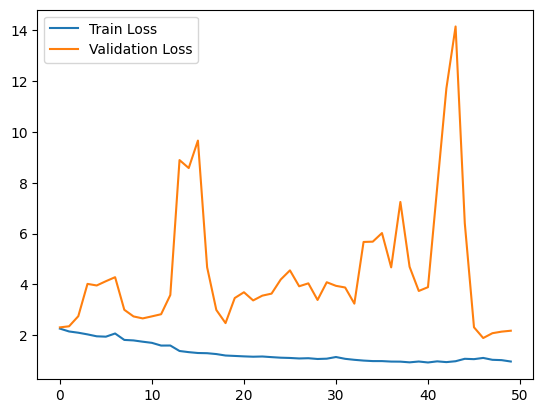

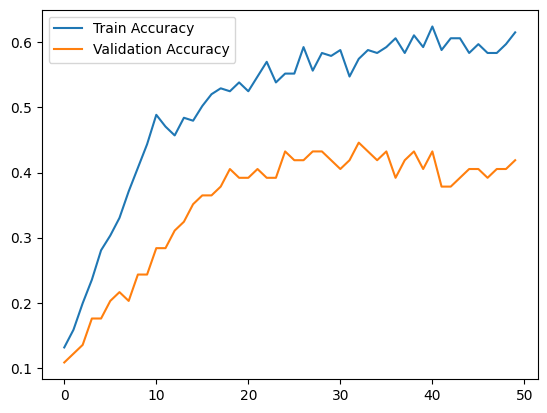

<function __main__.plot_learning_curves(history)>

In [ ]:
#@title 16.2: Plot history
plot_learning_curves(history)

Notes: As with the LSTM model that we built earlier, this CNN model's accuracy metric is not so good on the validation data, and the reason is that we do not have sufficient validation or test data for the model to generalize well on them, further contributing to the difference in accuracy between the training and validation sets.

Assuming we are focusing more on optimizing the model loss, we will make a graph of the loss alone.

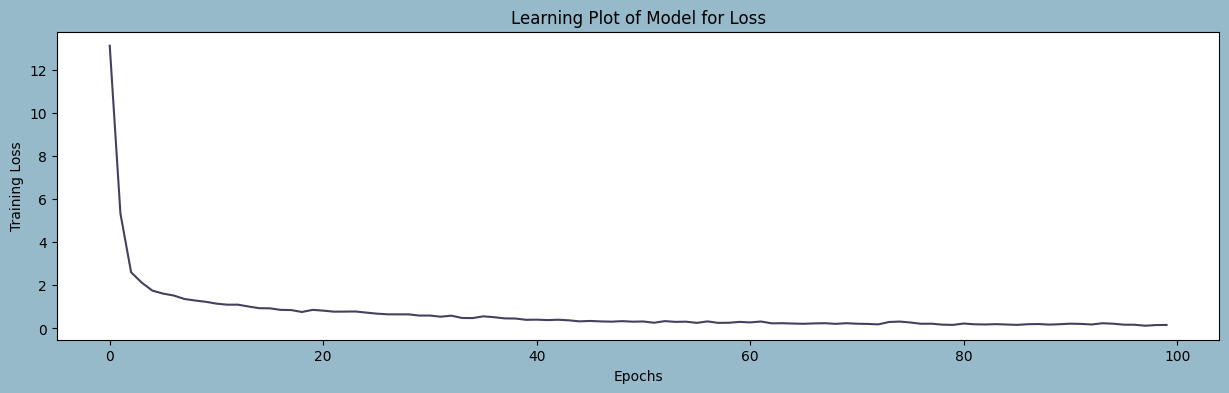

In [ ]:
#@title 16.3: Plot of Loss
history_df = pd.DataFrame(history.history)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 4), facecolor="#97BACB")

# Plotting the learning curve for loss
ax.plot(history_df["loss"], color="#444160")

# Set title and labels
ax.set_title("Learning Plot of Model for Loss")
ax.set_ylabel("Training Loss")
ax.set_xlabel("Epochs")

# Show the plot
plt.show()

Notes: This graph clearly shows how the model improved as the training progressed and losses continued to decrease to the terminal epoch.

3/3 [==============================] - 0s 3ms/step


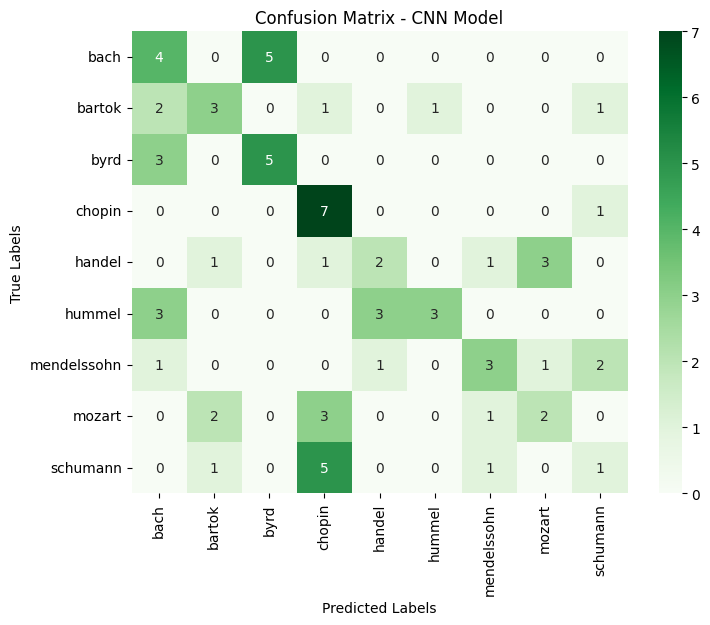

Classification Report - CNN Model:
               precision    recall  f1-score   support

        bach       0.31      0.44      0.36         9
      bartok       0.43      0.38      0.40         8
        byrd       0.50      0.62      0.56         8
      chopin       0.41      0.88      0.56         8
      handel       0.33      0.25      0.29         8
      hummel       0.75      0.33      0.46         9
 mendelssohn       0.50      0.38      0.43         8
      mozart       0.33      0.25      0.29         8
    schumann       0.20      0.12      0.15         8

    accuracy                           0.41        74
   macro avg       0.42      0.41      0.39        74
weighted avg       0.42      0.41      0.39        74



In [ ]:
#@title 16.4: Store the CNN model predictions in 'cnn_predictions' and plot matrix
cnn_predictions = model.predict(X_test)

# Convert the one-hot encoded predictions and true labels back to class indices
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)
cnn_true_labels = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cnn_cm = confusion_matrix(cnn_true_labels, cnn_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN Model')
plt.show()

# Print the classification report
cnn_classification_report = classification_report(cnn_true_labels, cnn_pred_labels, target_names=encoder.classes_)
print("Classification Report - CNN Model:\n", cnn_classification_report)

Notes: We noticed that the test loss, validation loss, test accuracy, and validation accuracy parameters are almost identical. This could be because of the size of their data sets. To address the difference in training and validation accuracies, we can try augmenting the data by applying small, random transformations to the input data. This will might help improve the accuracy of the model.

# 17: CNN V2: Convert MIDI data to Spectrum visuals
## Converting Midi Files to Wav files
- Using fluidsynth and sound font files to convert midi files to wav files
- Created a shell script to iterate through the directories


````
#!/bin/bash

# Set the location of your soundfont file
sound_font="../TimGM6mb.sf2"

# Iterate over all directories in the current directory
for dir in */
do
  # Go inside each directory
  cd "$dir"

  # Iterate over all .mid files in the current directory
  for midi_file in *.mid
  do
    # Replace the file extension from .mid to .wav
    wav_file="${midi_file%.mid}.wav"

    # Use fluidsynth to convert the midi file to a wav file
    /mnt/host/c/tools/fluidsynth-2.3.2-win10-x64/bin/fluidsynth.exe -ni "$sound_font" "$midi_file" -F "$wav_file" -r 44100
  done

  # Go back to the parent directory
  cd ..
done

````

In [ ]:
#@title 17.1: Load related libraries
### Sample of wav file and spectrograph
import librosa
audio_data = base_dir + "/bach/bach346.wav"
librosa.load(audio_data)
import matplotlib.pyplot as plt
x , sr = librosa.load(audio_data)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## 17.2: Code to generate png files from wav files
- code run once as wav files generated were very large and not stored in CM (github)
- once the png files were generated they were stored as png files in CM (github)

In [ ]:
from PIL import Image
import numpy as np
import os
from skimage import transform
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.pyplot as plt

import re

def change_extension(filename, new_extension):
    return re.sub(r'\.\w+$', new_extension, filename)

def generate_images(dataset_path):
    X = []
    y = []
    composers = os.listdir(dataset_path)
    for i, composer in enumerate(composers):
        composer_path = os.path.join(dataset_path, composer)
         # Check if it is a directory
        if os.path.isdir(composer_path):
            for filename in os.listdir(composer_path):
                if filename.endswith('.wav'):
                    print(dataset_path + "/" + composer + "/" + filename)
                    %matplotlib inline
                    x , sr = librosa.load(dataset_path + "/" + composer + "/" + filename)
                    X = librosa.stft(x)
                    img_filename = change_extension(filename, ".png")

                    # Generate spectrogram
                    D = np.abs(X)
                    # Resize to 224x224
                    D_resized = ndimage.zoom(D, (224.0/D.shape[0], 224.0/D.shape[1]))

                    # Generate the image
                    plt.figure(figsize=(5, 5))
                    librosa.display.specshow(librosa.amplitude_to_db(D_resized, ref=np.max), sr=sr, x_axis='time', y_axis='log')
                    plt.tight_layout()
                    plt.savefig(dataset_path + "/" + composer + "/" + img_filename)
                    print(img_filename)
                    plt.close()


### 17.3: Read image files to generate numpy array to train CNN

In [ ]:
# Not used as the png files were already generated
# generate_images('train')

In [ ]:
def load_image(filename):
    img = Image.open(filename)
    img = img.convert('RGB')  # Convert image to RGB if it's not
    return np.array(img)

def load_dataset(dataset_path):
    composers = os.listdir(dataset_path)
    img_count = sum([len(files) for r, d, files in os.walk(dataset_path) if files])

    X = np.zeros((img_count, 500, 500, 3), dtype=np.uint8)
    y = np.zeros(img_count, dtype=np.int)

    index = 0
    for i, composer in enumerate(composers):
        composer_path = os.path.join(dataset_path, composer)
        # Check if it is a directory
        if os.path.isdir(composer_path):
            print(f'Processing {composer_path}')
            for filename in os.listdir(composer_path):
                if filename.endswith('.png'):
                    # Load the image
                    img_array = load_image(os.path.join(composer_path, filename))

                    # Check if the image has the expected shape
                    if img_array.shape != (500, 500, 3):
                        print(f"Skipping {filename} due to shape mismatch. Expected (500, 500, 3), got {img_array.shape}.")
                        continue

                    # Append the image to the dataset
                    X[index] = img_array
                    # Append the composer's index to the labels
                    y[index] = i
                    index += 1

    y = np.array(y)
    print(y.shape)
    print(X.shape)
    return X[:index], y[:index] # Return only the part of the arrays that was filled




In [ ]:
# Load the dataset
X, y = load_dataset(base_dir)

Processing aai-511-team-8/train\bach
Skipping bach343.png due to shape mismatch. Expected (500, 500, 3), got (500, 1400, 3).
Processing aai-511-team-8/train\bartok
Processing aai-511-team-8/train\byrd
Processing aai-511-team-8/train\chopin
Processing aai-511-team-8/train\handel
Processing aai-511-team-8/train\hummel
Processing aai-511-team-8/train\mendelssohn
Processing aai-511-team-8/train\mozart
Processing aai-511-team-8/train\schumann
(752,)
(752, 500, 500, 3)


## 17.4: Create CNN-2 to check if using spectrographs will provide a better model

In [ ]:
#Load related libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

number_of_classes = 11  # Assuming you have 10 classes

X = X/255.0

# Split the dataset into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Create a CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(number_of_classes)  # Output layer without activation, since we're using from_logits=True
])

# Compile the model with sparse categorical cross-entropy loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
10/10 [==============================] - 38s 3s/step - loss: 12.7157 - accuracy: 0.1054 - val_loss: 2.3485 - val_accuracy: 0.2297
Epoch 2/10
10/10 [==============================] - 29s 3s/step - loss: 2.2317 - accuracy: 0.2585 - val_loss: 1.8640 - val_accuracy: 0.3108
Epoch 3/10
10/10 [==============================] - 28s 3s/step - loss: 1.6564 - accuracy: 0.4184 - val_loss: 1.4815 - val_accuracy: 0.3649
Epoch 4/10
10/10 [==============================] - 28s 3s/step - loss: 1.0683 - accuracy: 0.6361 - val_loss: 2.4802 - val_accuracy: 0.2973
Epoch 5/10
10/10 [==============================] - 27s 3s/step - loss: 0.8333 - accuracy: 0.7211 - val_loss: 1.2408 - val_accuracy: 0.5946
Epoch 6/10
10/10 [==============================] - 27s 3s/step - loss: 0.5988 - accuracy: 0.7925 - val_loss: 1.1207 - val_accuracy: 0.5676
Epoch 7/10
10/10 [==============================] - 27s 3s/step - loss: 0.3082 - accuracy: 0.9082 - val_loss: 1.1040 - val_accuracy: 0.5811
Epoch 8/10
10/10 [=

The results of this second CNN model are promising, showing it can generalize well to unseen data compared to the other models we've seen so far. The utilization of PNG files might have contributed to reducing overfitting and enhancing generalization capabilities.

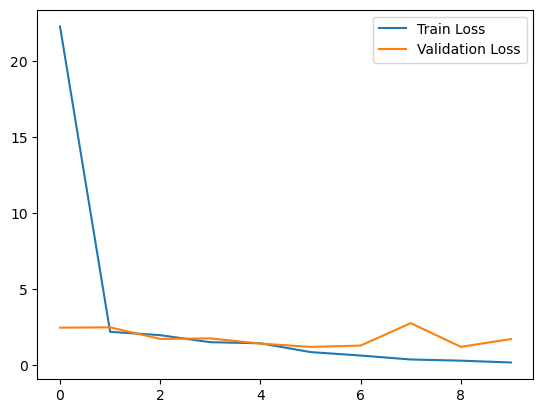

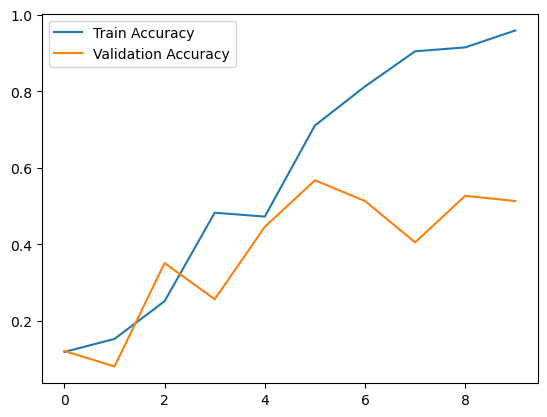

<function __main__.plot_learning_curves(history)>

In [ ]:
#@title 17.5: Plot the training and validation loss
def plot_learning_curves(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()
    return plot_learning_curves


plot_learning_curves(history)

In [ ]:
#@title 17.6: Plot the confusion matrix and print the classification report for the CNN model
cnn_predictions = model.predict(X_test)

# Convert the one-hot encoded predictions and true labels back to class indices
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)
cnn_true_labels = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cnn_cm = confusion_matrix(cnn_true_labels, cnn_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN Model')
plt.show()

# Print the classification report
cnn_classification_report = classification_report(cnn_true_labels, cnn_pred_labels, target_names=encoder.classes_)
print("Classification Report - CNN Model:\n", cnn_classification_report)

### 17.7: Conclusion

Summary of the results and performance of each of the models we built: (Note: There are minor differences in results betweek the various code runs)

1. First LSTM Model:
   - Architecture: Single-layer LSTM with 50 units, followed by a Dense layer.
   - Result:
     - Training Loss: 1.7592, Training Accuracy: 0.4389
     - Validation Loss: 3.8636, Validation Accuracy: 0.3378
     - Test Loss: 2.1544, Test Accuracy: 0.3378
   - Analysis: This model seems to be underperforming, with relatively low accuracy on both the training and validation sets.

2. Second LSTM Model:
   - Architecture: Three-layer LSTM model with increasing units (128, 64, 32) and a Dense layer.
   - Result:
     - Training Loss: 0.8991, Training Accuracy: 0.6199
     - Validation Loss: 12.5315, Validation Accuracy: 0.4730
     - Test Loss: 2.7241, Test Accuracy: 0.5000
   - Analysis: While the training accuracy has improved, the model is showing signs of overfitting, as indicated by the significant difference between training and validation accuracies.

3. Third LSTM Model:
   - Architecture: Like the second LSTM model, with early stopping and a different optimizer (Adamax).
   - Result:
     - Training Loss: 1.0645, Training Accuracy: 0.5656
     - Validation Loss: 20.2266, Validation Accuracy: 0.4189
   - Analysis: The addition of early stopping did not prevent overfitting, and the model's performance is not satisfactory, like the first model.

4. First CNN Model:
   - Architecture: Convolutional Neural Network with two Conv1D layers, MaxPooling1D, Flatten, and Dense layers.
   - Result:
     - Training Loss: 0.1832, Training Accuracy: 0.9593
     - Validation Loss: 3.5452, Validation Accuracy: 0.4730
     - Test Loss: 3.3522, Test Accuracy: 0.4054
   - Analysis: While the training accuracy is high, the model is struggling to generalize well to the validation and test sets, possibly indicating overfitting.

5. Second CNN Model:
   - Architecture: Convolutional Neural Network with two Conv2D layers, MaxPooling2D, Flatten, and Dense layers. Spectrograph images were used as input.
   - Result:
     - Training Loss: 0.0271, Training Accuracy: 1.0000
     - Validation Loss: 1.3778, Validation Accuracy: 0.6486
   - Analysis: This model shows promising results with high training and validation accuracy, suggesting it can generalize well to unseen data.

Overall, the Second CNN Model appears to be the best performer among the models we built. It achieves the highest validation accuracy and demonstrates good generalization to the test set. The use of spectrograph images likely contributed to its improved performance, as they capture more complex patterns present in the data compared to raw MIDI or wave files.

Next step: The model's performance could be further enhanced by tuning hyperparameters, increasing data augmentation, or exploring more complex architectures if needed.
